In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

%matplotlib inline

from pathlib import Path
import importlib.resources as pkg_resources
import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm.auto import tqdm

import captchanet

data_dir = Path('/home/hadim/.data/Neural_Network/captchanet')

dataset_dir = data_dir / 'dataset_v6'
train_data_dir = dataset_dir / 'training'
val_data_dir = dataset_dir / 'validation'

model_dir = data_dir / 'model'
model_name = 'v8'
model_path = model_dir / model_name

tokenizer_path = model_path / "tokenizer.json"

# Get tokenizer
with open(tokenizer_path) as f:
  #tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(f.read())
  from keras_preprocessing import text
  tokenizer = text.tokenizer_from_json(f.read())
  
model = tf.keras.models.load_model(str(model_path / 'model'))

In [2]:
# Define a model that do image preprocessing before inference.
class CaptchaSolverInferenceModel(tf.keras.Model):
  
  def __init__(self, captchanet_model, **kwargs):
    super().__init__(**kwargs)
    self.captchanet_model = captchanet_model

  @tf.function(input_signature=[tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8)])
  def solve(self, images):
    
    # Normalize images
    images = tf.cast(images, tf.float32)
    images = tf.image.per_image_standardization(images)
    images = tf.image.resize(images, (299, 299))
    
    # Inference
    labels = self.captchanet_model(images)
    labels = tf.argmax(labels, axis=2)
    labels = tf.cast(labels, tf.int32)
    
    # Freeze the tokenizer
    n_letter = max(tokenizer.index_word.keys()) + 1
    index = [''] * n_letter
    for k, v in tokenizer.index_word.items():
      index[k] = v
    index = tf.constant(index, dtype=tf.string)
        
    # Decode labels
    # CPU is reqired here because tf.string and tf.map_fn does not
    # seems compatible yet on GPU.
    with tf.device('/cpu:0'):
      decoder = lambda x: tf.gather_nd(index, tf.expand_dims(x, axis=-1))
      words = tf.map_fn(decoder, labels, dtype=tf.string)
      joiner = lambda x: tf.strings.reduce_join(x, axis=0)
      words = tf.map_fn(joiner, words, dtype=tf.string)

    return words
  
inference_model = CaptchaSolverInferenceModel(model)
inference_model_path = model_path / 'inference_model'
tf.saved_model.save(inference_model, str(inference_model_path))

W0715 09:49:40.599295 140323654940480 saved_model.py:758] Skipping full serialization of Keras model <__main__.CaptchaSolverInferenceModel object at 0x7f9e27235470>, because its inputs are not defined.
W0715 09:49:41.350095 140323654940480 deprecation.py:323] From /home/hadim/conda/envs/captchanet/lib/python3.7/site-packages/tensorflow/python/ops/image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0715 09:49:42.454817 140323654940480 saved_model.py:765] Skipping full serialization of Keras layer <tensorflow.python.keras.saving.saved_model.InputLayer object at 0x7f9e2e5b2ac8>, because it is not built.
W0715 09:49:42.457018 140323654940480 saved_model.py:765] Skipping full serialization of Keras layer <tensorflow.python.keras.saving.saved_model.KerasLayer object at 0x7f9e2e5b2ba8>, because it is not built.
W0715 09:49:42.460791 14032365494048

In [3]:
# Copy DATA_LICENSE and DATA_README to `model_path`
with open(model_path / 'DATA_LICENSE', 'w') as f:
  f.write(pkg_resources.read_text(captchanet, 'DATA_LICENSE'))
  
with open(model_path / 'DATA_README', 'w') as f:
  f.write(open(dataset_dir / 'DATA_README').read())
  
# Pack and zip the model directory
import shutil
archive_path = model_dir / model_path.stem
shutil.rmtree(model_path / '.ipynb_checkpoints', ignore_errors=True)
shutil.make_archive(archive_path, 'zip', root_dir=model_path)

'/home/hadim/.data/Neural_Network/captchanet/model/v7.zip'

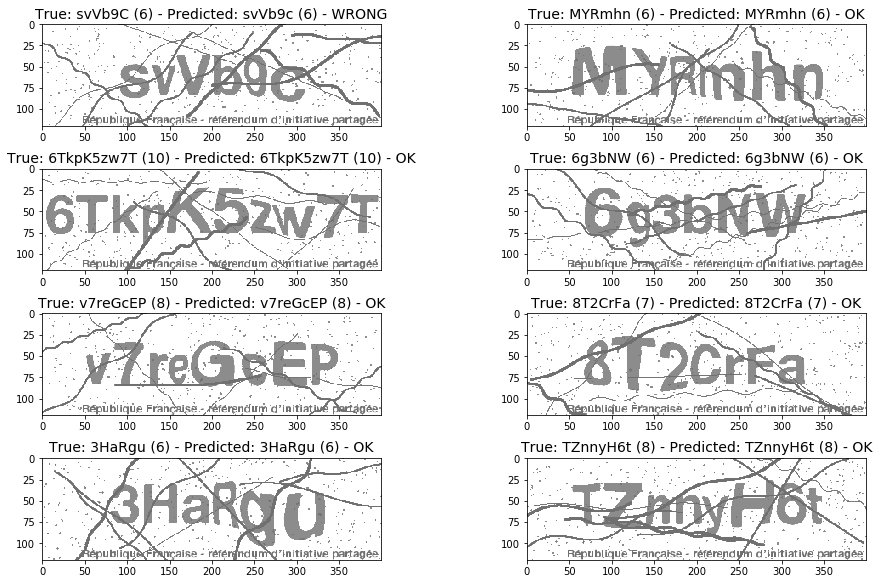

In [5]:
# Test the exported model

tf.keras.backend.clear_session()
inference_model = tf.saved_model.load(str(model_path / 'inference_model'))

model_image_size = (299, 299)
n  = 8
fnames = [str(p) for p in val_data_dir.glob("*.tfrecord")]
dataset = tf.data.TFRecordDataset(fnames)
dataset = dataset.map(map_func=captchanet.decode_data(tokenizer, image_size=model_image_size, max_len_word=10, input_as_dict=True))
dataset = dataset.shuffle(1024)
dataset = dataset.batch(n)
data = [d for d in dataset.take(1)][0]

images = data['original_image']

# Solve captcha
predicted_words = inference_model.solve(images)
predicted_words = predicted_words.numpy()

# Plot
original_images = data['original_image'].numpy()
words = data['word'].numpy()
words = [w.decode('utf-8').replace('0', '') for w in words]

size = 2
ncols = 2
nrows = n // ncols
ratio = original_images.shape[2] / original_images.shape[1]
figsize = (ncols * size * ratio, size * nrows)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
axs = axs.flatten()

for image, word, predicted_word, ax in zip(images, words, predicted_words, axs):
  ax.imshow(image)
  
  predicted_word = predicted_word.decode()
  mark = 'OK' if predicted_word == word else 'WRONG'
  text = f'True: {word} ({len(word)})'
  text += f' - Predicted: {predicted_word} ({len(predicted_word)})'
  text += f" - {mark}"
  ax.set_title(text, fontsize=14)